<a href="https://colab.research.google.com/github/katemcg/assignment3/blob/main/assignment3_Part2_3_hs3458_kem2231.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center"><h1 align="center">QMSS5074GR <br> Projects in Advanced Machine Learning <br>Spring 2024 <br> FINAL PROJECT <br>Assignment 3 Part 2 [GROUP Assignment]</h1>

---
<br>

#### **Your Unis** : hs3458, kem2231
#### **Your Full names** : Harini Sundararajan, Kate McGrath
#### **Your AI Model Share Usernames**: harinisund, kem2231
#### **Link to your Public Github repository** : https://github.com/katemcg/assignment3
#### **Team member Contribution Percentages** : Fill here

The highest achievable marks are 120, with there being 20 extra credits. The overall distribution of marks is as follows:

Part 1:
EDA and basic ML models : [15 points]

Part 2:
Deep Learning Section: [60 Total possible]
Recurrent models : 20 points
3 other models (CNN and Transformers) : 22 points + 10 Extra credits
Results : 8 points


Github Section : [45 Total possible]
Inference pipeline : 25 Points + 10 Extra credits
Readme + Report : 10 points

Heavy weightage (45 total possible marks) is assigned to the last section. Please be mindful of the time required to complete the last section as it is non-trivial and the most important part of the final project. Read instructions on how to score Zero marks and how to score 45 marks on this.

## Stanford Sentiment Treebank - Movie Review Classification Competition


## **Instructions: [Total 85 Points for this part]**
1.   Get data in and set up X_train / X_test / y_train
2.   Preprocess data using keras Tokenizer/ Write and Save Preprocessor function
3. Fit model on preprocessed data and save preprocessor function and model
4. Generate predictions from X_test data and submit model to competition
5. Repeat submission process to improve place on leaderboard



## 1. Get data in and set up X_train, X_test, y_train objects

In [ ]:
#install aimodelshare library
! pip install aimodelshare

In [ ]:
# Get competition data
from aimodelshare import download_data
download_data('public.ecr.aws/y2e2a1d6/sst2_competition_data-repository:latest')


Data downloaded successfully.


In [ ]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## IMPORTANT NOTE
This X_test has no relation to test_sample.csv
This X_test (downloaded from above link) is for prediction and submission to aimodelshare only. You can create a validation split from the X_train here or during instatiating the model.

The test_sample.csv is meant for only inference from your best 3 saved models, and is only meant to be used in the final front-end notebook (See last section, Note that it has a very high weightage in this assignment). Predicting the labels in correct format on this test_sample may also require you to change your preprocessing and transform code. Ensure you code it correctly and that your final front-end notebook can predict on it appropriately.

None of the training code in this notebook will go into your python files in Github or your front-end notebook (See last cell instructions)

In [1]:
# Set up X_train, X_test, and y_train_labels objects
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=Warning)

X_train=pd.read_csv("X_train.csv")
X_test=pd.read_csv("X_test.csv")
y_train_labels=pd.read_csv("y_train_labels.csv")

# Convert to series if your following preprocessor needs it
def to_series(df):
  if len(df.columns) == 1:
    return(df.squeeze())

X_train = to_series(X_train)
X_test = to_series(X_test)
y_train_labels = to_series(y_train_labels)

# One hot encode encode Y data here
y_train = pd.get_dummies(y_train_labels)

X_train.head()

0    The Rock is destined to be the 21st Century 's...
1    The gorgeously elaborate continuation of `` Th...
2    Singer/composer Bryan Adams contributes a slew...
3                 Yet the act is still charming here .
4    Whether or not you 're enlightened by any of D...
Name: text, dtype: object

##2.   Preprocess data using keras tokenizer / Write and Save Preprocessor function


In [2]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [3]:
# This preprocessor function makes use of the tf.keras tokenizer

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# [3 Pts]for this cell

# Build vocabulary from training text data

# preprocessor tokenizes words and makes sure all documents have the same length (perform padding with maxlen=40)

def preprocessor(texts, maxlen=40):
    """
    Preprocesses a list of texts using pre-defined functions to clean text and remove stopwords, tf.keras Tokenizer and pads sequences to a fixed length.

    Args:
    texts: List of strings representing input texts.
    maxlen: Maximum length of sequences after padding, set to 40.

    Returns:
    padded_sequences: Numpy array of padded sequences.
    tokenizer: Tokenizer object fitted on the input texts.
    """

    texts = texts.apply(clean_text)

    texts = texts.apply(remove_stopwords)

    # Initialize Tokenizer
    tokenizer = Tokenizer()

    # Fit tokenizer on input texts
    tokenizer.fit_on_texts(texts)

    # Convert texts to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad sequences to a fixed length
    padded_sequences = pad_sequences(sequences, maxlen)

    return padded_sequences, tokenizer

print(preprocessor(X_train)[0].shape)
print(preprocessor(X_test)[0].shape)

(6920, 40)
(1821, 40)


##3. Fit model on preprocessed data and save preprocessor function and model


In [ ]:
from tensorflow.keras.layers import Dense, Embedding,Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

padded_sequences, tokenizer = preprocessor(X_train)

# A basic deep learning model (max 5 layers)  # [1 Pts]
# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=40))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = "model_checkpoint.h5"

red_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs
mod_check = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Fit the model with validation split
history = model.fit(padded_sequences, y_train,
                    batch_size=32, epochs=30, validation_split=0.2,
                    callbacks = [red_lr, mod_check, early_stop])

Epoch 1/30
173/173 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.6096
Epoch 00001: val_accuracy improved from -inf to 0.14884, saving model to model_checkpoint.h5
173/173 [==============================] - 6s 26ms/step - loss: 0.6755 - accuracy: 0.6096 - val_loss: 0.8759 - val_accuracy: 0.1488 - lr: 0.0010
Epoch 2/30
172/173 [============================>.] - ETA: 0s - loss: 0.6115 - accuracy: 0.6533
Epoch 00002: val_accuracy improved from 0.14884 to 0.68569, saving model to model_checkpoint.h5
173/173 [==============================] - 3s 19ms/step - loss: 0.6117 - accuracy: 0.6535 - val_loss: 0.6326 - val_accuracy: 0.6857 - lr: 0.0010
Epoch 3/30
171/173 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9161
Epoch 00003: val_accuracy improved from 0.68569 to 0.68786, saving model to model_checkpoint.h5
173/173 [==============================] - 3s 18ms/step - loss: 0.2452 - accuracy: 0.9156 - val_loss: 0.7927 - val_accuracy: 0.6879 - lr:

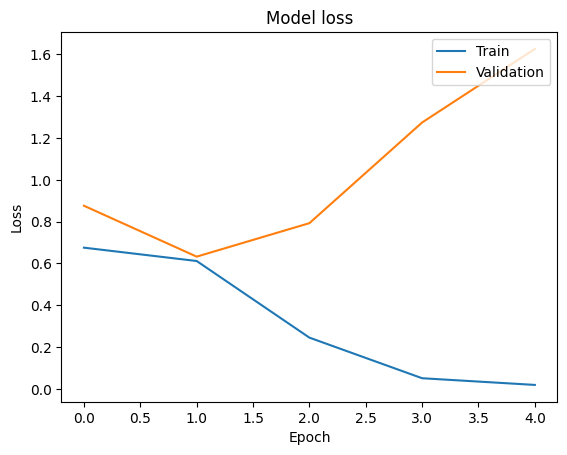

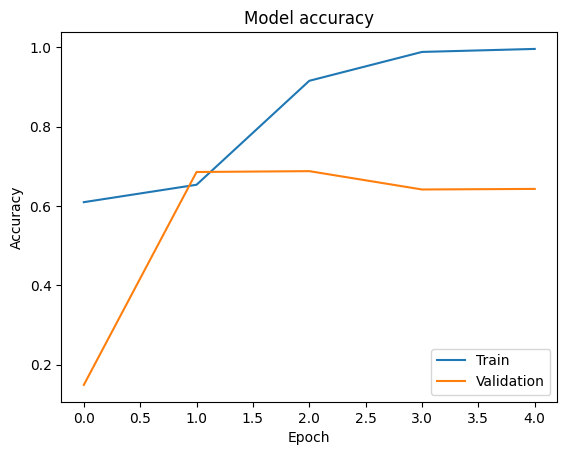

In [ ]:
# Plot history [1 Pts]
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### Save preprocessor function to local "preprocessor.zip" file

In [ ]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"preprocessor.zip")

[Errno 2] No such file or directory: 'preprocessor.zip/preprocessor.zip'
Your preprocessor is now saved to 'preprocessor.zip'


#### Save model to local ".onnx" file

In [ ]:
# Save keras model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                           transfer_learning=False,
                           deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

## 4. Generate predictions from X_test data and submit model to competition


In [ ]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials

apiurl="https://rlxjxnoql9.execute-api.us-east-1.amazonaws.com/prod/m" #This is the unique rest api that powers this specific Playground

set_credentials(apiurl=apiurl)

In [ ]:
#Instantiate Competition

mycompetition= ai.Competition(apiurl)

In [ ]:
#Submit Model 1:

# [1 Pts]

#-- Generate predicted y values on x_test (Model 1)
prediction_labels = model.predict(preprocessor(X_test))

# extract correct prediction labels
model_filepath = "model.onnx"
preprocessor_filepath = "preprocessor.zip"

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model = "model.onnx",
                           preprocessor="preprocessor.zip",
                           prediction_submission=prediction_labels)

In [ ]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)

## 5. Repeat submission process to improve place on leaderboard


In [ ]:
# Train and submit model 2 using same preprocessor (note that you could save a new preprocessor, but we will use the same one for this example).
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten

# Code an model with atleast 3 LSTM layers (with Embedding Layer) # [1 Pts]
# Define the model architecture
model2 = Sequential()
model2.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=40))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(32, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(16))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax'))

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with validation split
history2 = model2.fit(padded_sequences, y_train,
                      batch_size=32, epochs=30, validation_split=0.2,
                      callbacks = [red_lr, mod_check, early_stop])

Epoch 1/30
173/173 [==============================] - ETA: 0s - loss: 0.6585 - accuracy: 0.6203
Epoch 00001: val_accuracy did not improve from 0.68786
173/173 [==============================] - 30s 84ms/step - loss: 0.6585 - accuracy: 0.6203 - val_loss: 0.7602 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
173/173 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8389
Epoch 00002: val_accuracy improved from 0.68786 to 0.72038, saving model to model_checkpoint.h5
173/173 [==============================] - 12s 71ms/step - loss: 0.3833 - accuracy: 0.8389 - val_loss: 0.6019 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 3/30
173/173 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9458
Epoch 00003: val_accuracy did not improve from 0.72038
173/173 [==============================] - 12s 71ms/step - loss: 0.1530 - accuracy: 0.9458 - val_loss: 1.0612 - val_accuracy: 0.6973 - lr: 0.0010
Epoch 4/30
173/173 [==============================] - ETA: 0s - loss

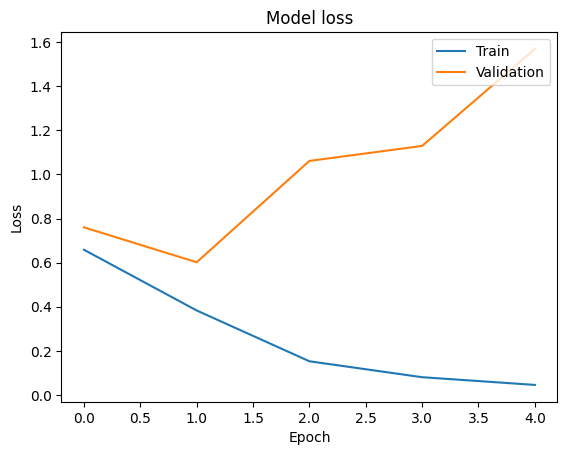

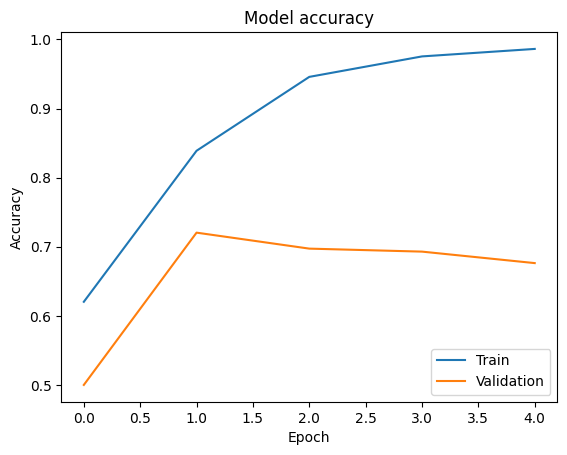

In [ ]:
# Plot history [1 Pts]
# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Does your model perform better or worse than your prior deep learning model? Why might that be the case?

In [ ]:
# Answer [1 Pts]

# this second model performs better, now with a validation accuracy of 0.72038
  # compared to 0.68786 for the first. so, the difference is only marginal, and
  # both models appear to be victims of overfitting, as the training accuracy
  # quickly reaches 1. still, some benefits of the second model using LSTM is
  # that it is intended to be used in situations where RNNs fail.

In [ ]:
# Save keras model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model2, framework='keras',
                           transfer_learning=False,
                           deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Submit Model 2:

#-- Generate predicted y values (Model 2)
prediction_labels = model.predict(preprocessor(X_test))

# extract correct prediction labels
model_filepath = "model2.onnx"
preprocessor_filepath = "preprocessor.zip"

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model = "model2.onnx",
                           preprocessor="preprocessor.zip",
                           prediction_submission=prediction_labels)

In [ ]:
# Compare two or more models
data=mycompetition.compare_models([1, 2], verbose=1)
mycompetition.stylize_compare(data)

## Tune model within range of hyperparameters with Keras Tuner


*Consult [documentation](https://keras.io/guides/keras_tuner/getting_started/) to see full functionality.*

In [ ]:
! pip install keras_tuner

In [ ]:
#Separate validation data here
from sklearn.model_selection import train_test_split
X_train_split, X_val, y_train_split, y_val = train_test_split(
     padded_sequences, y_train, test_size=0.2, random_state=42)

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout
import keras_tuner as kt

# Define model structure & parameter search space with a function
# code LSTM--based model with provision for searching hyperparameter space, return model  # [3 Pts]
# Define the model structure with hyperparameters

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=40))
    for i in range(hp.Int('num_lstm_layers', 1, 3)):  # Number of LSTM layers (1 to 3)
        model.add(LSTM(units=hp.Int(f'lstm_{i}_units', min_value=32, max_value=128, step=32), return_sequences=True))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout after each LSTM layer
    model.add(LSTM(16))  # Final LSTM layer
    model.add(Dropout(0.2))  # Dropout after the final LSTM layer
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#initialize the keras search tuner (which will search through parameters)   # [3 Pts]
# Define the following:
#Your function that returns the model
#objective to optimize
#max number of trials to run during search
#higher number reduces variance of results; guages model performance more accurately

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5
)

# Run the tuner feeding it the validation data
tuner.search(X_train_split, y_train_split,
             validation_data=(X_val, y_val), epochs=30,
             callbacks = [red_lr, mod_check, early_stop])

Trial 5 Complete [00h 02m 57s]
val_accuracy: 0.7528901696205139

Best val_accuracy So Far: 0.7666184902191162
Total elapsed time: 00h 13m 22s


In [ ]:
# [3 Pts]

# Build model with best hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=2)  # Get the top 2 hyperparameters

# Iterate over the top hyperparameters
for hp in best_hps:
    # Build the model with the best hyperparameters
    tuned_model = build_model(hp)
    # Fit the model with the entire dataset
    tuned_model.fit(padded_sequences, y_train, epochs=30, batch_size=32, callbacks = [red_lr, mod_check, early_stop], validation_split=0.2)

Epoch 1/30
173/173 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.6628
Epoch 00001: val_accuracy did not improve from 0.72110
173/173 [==============================] - 49s 233ms/step - loss: 0.6124 - accuracy: 0.6628 - val_loss: 0.6602 - val_accuracy: 0.6163 - lr: 0.0010
Epoch 2/30
173/173 [==============================] - ETA: 0s - loss: 0.2785 - accuracy: 0.8895
Epoch 00002: val_accuracy did not improve from 0.72110
173/173 [==============================] - 24s 138ms/step - loss: 0.2785 - accuracy: 0.8895 - val_loss: 0.6484 - val_accuracy: 0.7088 - lr: 0.0010
Epoch 3/30
173/173 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9626
Epoch 00003: val_accuracy did not improve from 0.72110
173/173 [==============================] - 24s 141ms/step - loss: 0.1019 - accuracy: 0.9626 - val_loss: 1.1386 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 4/30
173/173 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9857
Epoch 0000

What were the best hyperparameters found? Why might that be performing better than others?

In [ ]:
# Answer [2 Pts]
for hp in best_hps:
  print(hp.values)

# as seen below, the two models with the best hyperparams have some very similar
  # features, such as the 2 lstm layers, first dropout layer at 0.2, and the
  # second lstm layer with 32 units. of these two best models, the second performed
  # better, and it has additional hyperparams that may have allowed for this to
  # be the case.

{'num_lstm_layers': 2, 'lstm_0_units': 128, 'dropout_0': 0.2, 'lstm_1_units': 32, 'dropout_1': 0.2}
{'num_lstm_layers': 2, 'lstm_0_units': 32, 'dropout_0': 0.2, 'lstm_1_units': 32, 'dropout_1': 0.4, 'lstm_2_units': 96, 'dropout_2': 0.30000000000000004}


In [ ]:
# Save keras model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(tuned_model, framework='keras',
                           transfer_learning=False,
                           deep_learning=True)

with open("tuned_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Submit Model 3:

#-- Generate predicted y values (Model 3)
prediction_labels = tuned_model.predict(preprocessor(X_test))

# extract correct prediction labels
model_filepath = "tuned_model.onnx"
preprocessor_filepath = "preprocessor.zip"

# Submit Model 3 to Competition Leaderboard
mycompetition.submit_model(model = "tuned_model.onnx",
                           preprocessor="preprocessor.zip",
                           prediction_submission=prediction_labels)

In [ ]:
# Get leaderboard

data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

In [ ]:
# Compare two or more models
data=mycompetition.compare_models([1, 2, 3], verbose=1)
mycompetition.stylize_compare(data)

## 3 more models [30 Pts]

Train three more prediction models to try to predict the SST sentiment
dataset well.

○ Use Conv1d layers in first model [ 2 Pts]

○ Use Transfer learning with Glove Embeddings for 2nd model [10 Pts]

○ Third model can be any Transfer learning model of your choice (Transformer architecture required, eg. BERT and related) [10 Pts]

In [4]:
from sklearn.model_selection import train_test_split

padded_sequences, tokenizer = preprocessor(X_train)

X_train_split, X_val, y_train_split, y_val = train_test_split(
     padded_sequences, y_train, test_size=0.2, random_state=42)

from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = "model_checkpoint.h5"

red_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs
mod_check = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [ ]:
# Model 1
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout
import keras_tuner as kt

def build_model_conv1d(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=40))

    # Add Conv1D layers
    for i in range(hp.Int('num_conv1d_layers', 1, 3)):  # Number of Conv1D layers (1 to 3)
        model.add(Conv1D(filters=hp.Int(f'conv1d_{i}_filters', min_value=32, max_value=128, step=32),
                         kernel_size=hp.Int(f'conv1d_{i}_kernel_size', min_value=3, max_value=5, step=2),
                         activation='relu'))
        model.add(GlobalMaxPooling1D())  # Apply global max pooling after each Conv1D layer

    # Add Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer for regularization
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model_conv1d,
    objective='val_accuracy',
    max_trials=5
)

# Run the tuner
tuner.search(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=30, callbacks = [red_lr, mod_check, early_stop])

# Build model with best hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=2)  # Get the top 2 hyperparameters

# Iterate over the top hyperparameters
for hp in best_hps:
    # Build the model with the best hyperparameters
    model = build_model_conv1d(hp)
    # Fit the model with the entire dataset
    model.fit(padded_sequences, y_train, epochs=30, batch_size=32, callbacks = [red_lr, mod_check, early_stop], validation_split=0.2)

In [ ]:
# saving model 1

model.save("model_conv.h5", save_format="h5")

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

import zipfile
zip_ref = zipfile.ZipFile("glove.6B.zip", 'r')
zip_ref.extractall(".")
zip_ref.close()

In [ ]:
# Model 2
from tensorflow.keras.initializers import Constant
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout
import keras_tuner as kt

# Load pre-trained GloVe embeddings
embeddings_index = {}
embedding_dim = 100  # Assuming you want to use 100-dimensional GloVe embeddings
glove_file = 'glove.6B.100d.txt'  # Path to the GloVe embeddings file

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare embedding matrix
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the model architecture
def build_model_glove(hp):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=40, trainable=False))  # Use pre-trained GloVe embeddings

    for i in range(hp.Int('num_lstm_layers', 1, 3)):  # Number of LSTM layers (1 to 3)
        model.add(LSTM(units=hp.Int(f'lstm_{i}_units', min_value=32, max_value=128, step=32),
                       return_sequences=True))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout after each LSTM layer

    model.add(LSTM(16))  # Final LSTM layer
    model.add(Dropout(0.2))  # Dropout after the final LSTM layer
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model_glove,
    objective='val_accuracy',
    max_trials=5
)

# Run the tuner
tuner.search(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=30, callbacks = [red_lr, mod_check, early_stop])

# Build model with best hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=2)  # Get the top 2 hyperparameters

# Iterate over the top hyperparameters
for hp in best_hps:
    # Build the model with the best hyperparameters
    model = build_model_glove(hp)
    # Fit the model with the entire dataset
    model.fit(padded_sequences, y_train, epochs=30, batch_size=32, callbacks = [red_lr, mod_check, early_stop], validation_split=0.2)

In [ ]:
# saving model 2

model.save("model_glove.h5", save_format="h5")

We load the pre-trained GloVe embeddings and prepare an embedding matrix using the words in the tokenizer's vocabulary.
The Embedding layer of the model is initialized with the pre-trained GloVe embeddings using the Constant initializer, and we set trainable=False to freeze the embeddings during training.
The rest of the model architecture remains the same, and we use the Keras Tuner to search for the best hyperparameters while keeping the GloVe embeddings fixed.

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

In [ ]:
!pip install "tf-models-official==2.13.*"

In [7]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
# Model 3

# code based on https://www.tensorflow.org/text/tutorials/classify_text_with_bert

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(2, activation='softmax')(net)

    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(list(X_train[0:2])))

classifier_model.compile(optimizer = "adam",
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

history = classifier_model.fit(X_train, y_train,
                               validation_split=0.2, epochs=30,
                               callbacks = [red_lr, mod_check, early_stop])

Epoch 1/30
173/173 [==============================] - ETA: 0s - loss: 0.7159 - accuracy: 0.5697
Epoch 00001: val_accuracy improved from -inf to 0.14884, saving model to model_checkpoint.h5
173/173 [==============================] - 276s 2s/step - loss: 0.7159 - accuracy: 0.5697 - val_loss: 1.2492 - val_accuracy: 0.1488 - lr: 0.0010
Epoch 2/30
173/173 [==============================] - ETA: 0s - loss: 0.6104 - accuracy: 0.6794
Epoch 00002: val_accuracy improved from 0.14884 to 0.50506, saving model to model_checkpoint.h5
173/173 [==============================] - 238s 1s/step - loss: 0.6104 - accuracy: 0.6794 - val_loss: 1.1283 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 3/30
128/173 [=====================>........] - ETA: 54s - loss: 0.6336 - accuracy: 0.6707

In [ ]:
# saving model 3

model.save("model_bert.h5", save_format="h5")

### Extra credits : Train any models of your choice [+10 Extra Points]

In [ ]:
# Any modern models of your choice (should be released after BERT)

Tabularize results from ALL your models in this notebook and compare performance [5 Pts]

In [ ]:
# Define a function to evaluate model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# List of saved models
models = []

# Evaluate the models on the test data to obtain performance metrics
test_metrics = []
for model in models:
  test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=1) ## X_test, y_test??
  test_metrics.append({'Test Loss': test_loss,
                       'Test Accuracy': test_accuracy,
                       'Test Precision': test_precision,
                       'Test Recall': test_recall})

In [ ]:
metrics_df = pd.DataFrame({
    'Model': ['','',''],
    'Accuracy': [metrics['Test Accuracy'] for metrics in test_metrics],
    'Loss': [metrics['Test Loss'] for metrics in test_metrics],
    'Precision': [metrics['Test Precision'] for metrics in test_metrics],
    'Recall': [metrics['Test Recall'] for metrics in test_metrics]
    })

print(metrics_df)

Results Discussion : Point out why specific models may have performed better than others. and discuss failures if any. [3 Pts]

# Python Inference pipeline on unseen dataset [45 Points (35 Pts + 10 Extra Credits)]

## <b>Github Repo: </b>

## **Part 1. [25 Pts]**

You will exercise **Modularization** and Good Github organization: You should take the relevant code and make it into classes across different python (.py) files so that you can just import those files and/or classes and/or functions and/or modules, instantiate the model using them, load weights from your saved models, and start predicting on any new set of test reviews (an unseen larger test dataset).

Essentially, you should have a simple and clean **"front-end" notebook** where you download your trained and saved models from say a personal drive link, and have an inference pipeline ready within about **10 lines of code** to predict on any new unseen Movie reviews dataset after loading it from a csv.

This time you will provide a choice of 3 trained models to choose from (atleast 2 from the last 3 models section + extra credit section if you did it) . You will give us a list of strings as a comment, and should provide the functionality to just specify the model to load using one of the 3 strings. An outline is detailed below.

<br><br>
**We have provided a test_sample.csv with 100 rows for you to test your front-end notebook.**

Your notebook should import relevant classes and modules on the back-end, and should load weights and subsequently just take the "review" column of given test_sample.csv and predict 'positive' or 'negative' sentiment on it (see outline of code below). Use the "sentiment" column from the test_sample csv ONLY when finally comparing your own predictions with it and output a classification report.

You should use a local environment with all packages installed and an IDE like VScode or PyCharm etc. to be able to do this section efficiently. There is no aimodelshare invlved in this section, and there shouldn't be any mention of it.



<br><br>
### Environment Requirements
Include a pip requirements.txt file for your environment.
Use the following command to generate it automatically:

```$ pip freeze > requirements.txt```

When evaluating this section, we will run

```pip install -r requirements.txt```

to recreate the exact environment you have locally and then test your code.

**ENSURE** that this works as intended by creating another new virtual conda environment, cloning your own latest Github commit locally from scratch, installing packages using your requirements.txt file, and following all the instructions you provide in the Readme and the front-end notebook to run the inference pipeline on the sample data. We will do the exact same steps to replicate it, and then substitute test sample with the actual dataset to evaluate this section.




## Outline for front-end notebook:

In [ ]:
## You will include code to load the test_sample.csv in your Front-end notebok
## Note that this csv can be of any large length, and you will predict on it using one of 3 models you provide weights for.

In [ ]:
# Provide a comment like this:



### Hi User! Please choose a model between ["Glove150d", "DistillBERT", "GPT2"]

model_name = "DistillBERT"  # Choice to modify model name from your given list


## Now call appropriate class/function from backend to download relevant weights, instantiate specified model and load the weights, and return the loaded model, ready to predict

## load the test csv:
import pandas as pd

test_data = pd.read_csv("test_sample.csv")
test_reviews=test_data.review


In [ ]:
## Send the test reviews to a backend function after preprocessing to predict sentiment : USE "tqdm" while predicting to show progress bar, transform predictions as needed

## preprocessing and any other intermediate steps should be through backend code, not in the front-end notebook

## pull out test_data.sentiment now (ground truth), transform as needed and compare your predictions with it

## Output the classification report on these test reviews and plot confusion matrix at the end of the front-end notebook (You will actually be tested on a much larger test dataset, but it would be of the same format)

# Make sure your notebook can run your inference pipeline on the loaded test_sample.csv reviews.  

# **You will recieve a ZERO (0) for this section if any of the following cases are true:**
### - If there is no front-end notebook, or no python (.py) files where you have declared classes, modules and functions to delegate all the work in backend
### - If there is no requirements.txt file in your repo
### - If after installing requirements in a new environment, following the  instructions in your Readme or Notebook does not lead to any valid output upon running the front-end notebook.
### - If your notebook does not output the final classification report and matrix for at least 1 model after predicting on test_sample
### - If you include or run any Training code in your front-end notebook or python files in github repository
### - If you include more than 30 lines of code in the front-end notebook (apart from importing your functions, classes from your modules)
### - If you attempt to use the 'sentiment' column from the test_sample for any  purpose other than comparison of your final predictions with it, and transforming it if needed.



<br><br>
# **You will recieve 25 + 10 EXTRA points if you do this section well.**

### How to do this section well:

Get a proper understanding of object-oriented programming in python. Learn what classes and modules are if you don't know already. Try to **encapsulate all code** within appropriately named classes and its functions. Each class and function should have a specific isloated purpose. All the classes and functions you design would talk to each other efficiently and handle everything in the background without needing to get back to the front-end notebook for outputting or retreiving intermediate objects.

In the front-end notebook, you essentially only need to include code to send the model name to backend using 1 function, get the loaded model back, read and send the test reviews to backend for predicting with this loaded model, then load the ground truth and straight up output the classification report from the backend (less than 10 lines of code)

The majority of your code should never be exposed directly in python files without being inside a class or a function. Only explicitly needed global variables, imports or declarations should be done outside the scope of a function or a class.

<br><br>
### Documentation

Include **Docstrings** for each function and class, define the input parameters and outputs, what they are and what data type they are expected to be in.

Example of a good docstring:
```python
def calculate_rectangle_area(length: float, width: float) -> float:
    """
    Calculate the area of a rectangle.

    This function takes the length and width of a rectangle and returns its area. The calculation assumes that the input values are in the same unit and will return the area in that unit squared.

    Parameters:
    - length (float): The length of the rectangle. Must be a positive number.
    - width (float): The width of the rectangle. Must be a positive number.

    Returns:
    - area (float): The calculated area of the rectangle in the unit squared of the input measurements.

    Raises:
    - ValueError: If either the length or width is non-positive.

    """


    if length <= 0 or width <= 0:
        raise ValueError("Length and width must be positive numbers.")

    area = length * width

    return area
```



<br><br>
### **Part 2. [5 Pts]**

In the **README.md** file of your repository should be an overall outline of your experiments, including the models you trained succesfully and have results for - summarized in a tabular way. You can include other details in your readme as well, but not too detailed. Consider this an exposition of your project for someone who does not know anything about this project.


Include instructions on how to install requirements, how to run your front-end notebook and describe which 3 models you gave choice to load and predict on.


Include a tree structure of your files in the github repository.

Example:
```
$ tree
.
├── dir1
│   ├── file11.ext
│   └── file12.ext
├── dir2
│   ├── file21.ext
│   ├── file22.ext
│   └── file23.ext
├── dir3
├── file_in_root.ext
└── README.md

3 directories, 7 files
```

Look at different readme's across github to see how they are organized. Refer to [this resource](https://docs.github.com/en/get-started/writing-on-github/getting-started-with-writing-and-formatting-on-github/basic-writing-and-formatting-syntax) to learn how to format the file.

- Example of a [Good Readme File](https://github.com/hankcs/HanLP) (We have no affiliations with Author)
- Example of a [Bad Readme File](https://github.com/tstran155/AG-News-Topic-Classification-and-Topic-Modeling-using-Natural-Language-Processing)
- Example of an [Acceptable/OK Readme File](https://github.com/lonePatient/Bert-Multi-Label-Text-Classification)
: This is the minimum level at which you should have your Readme

Note that these examples are different from the last assignment.

<br><br>
### **Part 3. [5 Pts]**

In the **Final report** (.ipynb) notebook, put whatever code, visuals and results you think are relevant. It is open ended, you should not just post a copy of this notebook for it. It should be brief, clean and succinct as has been instructed before. No residues from the assignment should be present, it should look like a professional report of experiments conducted.





#### Do not forget to link the final Github repository containing the Front-end running notebook, your code, Readme and Final report at the top of this notebook.